Datasets
Data is separated into two datasets: information about the identity of the customer and transaction information. bold text

train_transaction : contains 590,540 rows and 394 features.
train_identity: contains 144,233 rows and 41 features.

Características da transação:

TransactionDT: Timedelta de um determinado datetime de referência (não um timestamp real), mas a diferença de tempo em segundos de um determinado horário.
TransactionAMT: Valor do pagamento da transação em USD, vale a pena prestar atenção na parte decimal.
ProductCD: Código do produto, o produto para cada transação. Pode não ser necessariamente um produto real, mas também pode se referir a um serviço.
card1-card6: Informações do cartão de pagamento, como tipo de cartão, categoria do cartão, banco emissor, país, etc.
addr1-addr2: Endereço, região de cobrança e país de cobrança
dist: Distâncias entre (não limitado) endereço de cobrança, endereço de correspondência, código postal, endereço IP, área de telefone, etc.
P_ e (R__) domínio de e-mail: domínio de e-mail do comprador e do destinatário, algumas transações não exigem o destinatário e o Remaildomain correspondente está vazio
C1-C14: Contagem, como quantos endereços estão associados ao cartão de pagamento, etc.
D1-D15: Timedelta, como dias entre transações anteriores, etc.
M1-M9: Correspondência, como nomes no cartão e endereço, etc.
Vxxx: Vesta desenvolveu recursos avançados, incluindo classificação, contagem e outras relações entre entidades. Alguns recursos V estão faltando em diferentes proporções.

Características de identidade:

id_01-id_11: Recursos numéricos para identidade, que são coletados pela Vesta e parceiros de segurança, como classificação do dispositivo, classificação ip_domain, classificação proxy etc. na página etc
DeviceType, DeviceInfo e id_12-id_38: recursos categóricos

In [1]:
#!pip install imblearn

In [2]:
#Bibliotecas
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import gc
import os
from sklearn.decomposition import PCA
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from time import time
from imblearn.over_sampling import SMOTE
import datetime
pd.set_option('display.float_format', lambda x: '%.3f' %x)

In [3]:
#Carregando os dados
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')

#Efetuar o merge pela coluna TransactionID
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')   

In [4]:
perc =[.20, .40, .60, .80]
train.describe(percentiles = perc)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,590540.000,590540.000,590540.000,590540.000,590540.000,581607.000,588975.000,586281.000,524834.000,524834.000,...,139369.000,45113.000,139318.000,139261.000,5159.000,5169.000,4747.000,5132.000,5163.000,77586.000
mean,3282269.500,0.035,7372311.310,135.027,9898.735,362.555,153.195,199.279,290.734,86.801,...,189.451,14.237,353.128,403.883,368.270,16.003,12.801,329.609,149.070,26.509
std,170474.358,0.184,4617223.647,239.163,4901.170,157.793,11.336,41.244,101.741,2.691,...,30.375,1.561,141.095,152.160,198.847,6.898,2.372,97.461,32.102,3.738
min,2987000.000,0.000,86400.000,0.251,1000.000,100.000,100.000,100.000,100.000,10.000,...,100.000,10.000,100.000,100.000,100.000,10.000,11.000,100.000,100.000,0.000
20%,3105107.800,0.000,2310159.600,35.950,4908.000,194.000,150.000,166.000,204.000,87.000,...,166.000,13.000,222.000,222.000,252.000,14.000,11.000,270.000,119.000,24.000
40%,3223215.600,0.000,5592303.600,57.950,8135.000,321.000,150.000,224.000,264.000,87.000,...,166.000,13.000,290.000,333.000,252.000,14.000,11.000,321.000,142.000,24.000
50%,3282269.500,0.000,7306527.500,68.769,9678.000,361.000,150.000,226.000,299.000,87.000,...,166.000,15.000,341.000,472.000,252.000,14.000,11.000,321.000,149.000,24.000
60%,3341323.400,0.000,8745782.400,100.000,11313.000,445.000,150.000,226.000,315.000,87.000,...,225.000,15.000,410.000,507.000,252.000,14.000,15.000,321.000,161.000,24.000
80%,3459431.200,0.000,12192853.600,159.950,15111.000,543.000,150.000,226.000,337.000,87.000,...,225.000,15.000,499.000,549.000,576.000,14.000,15.000,426.000,184.000,32.000
max,3577539.000,1.000,15811131.000,31937.391,18396.000,600.000,231.000,237.000,540.000,102.000,...,229.000,29.000,671.000,661.000,854.000,44.000,26.000,548.000,216.000,32.000


In [5]:
train.shape, train['isFraud'].value_counts() 

((590540, 434),
 0    569877
 1     20663
 Name: isFraud, dtype: int64)

In [6]:
#Verificando os NAN e dados faltantes
for i in train.columns:
    total_nan = train[i].isnull().sum()
    total = len(train)
    percent_nan = (total_nan / total) * 100
    print(f'{i} - Total de NaN: {total_nan}, Porcentagem de NaN: {percent_nan:.2f}%')

TransactionID - Total de NaN: 0, Porcentagem de NaN: 0.00%
isFraud - Total de NaN: 0, Porcentagem de NaN: 0.00%
TransactionDT - Total de NaN: 0, Porcentagem de NaN: 0.00%
TransactionAmt - Total de NaN: 0, Porcentagem de NaN: 0.00%
ProductCD - Total de NaN: 0, Porcentagem de NaN: 0.00%
card1 - Total de NaN: 0, Porcentagem de NaN: 0.00%
card2 - Total de NaN: 8933, Porcentagem de NaN: 1.51%
card3 - Total de NaN: 1565, Porcentagem de NaN: 0.27%
card4 - Total de NaN: 1577, Porcentagem de NaN: 0.27%
card5 - Total de NaN: 4259, Porcentagem de NaN: 0.72%
card6 - Total de NaN: 1571, Porcentagem de NaN: 0.27%
addr1 - Total de NaN: 65706, Porcentagem de NaN: 11.13%
addr2 - Total de NaN: 65706, Porcentagem de NaN: 11.13%
dist1 - Total de NaN: 352271, Porcentagem de NaN: 59.65%
dist2 - Total de NaN: 552913, Porcentagem de NaN: 93.63%
P_emaildomain - Total de NaN: 94456, Porcentagem de NaN: 15.99%
R_emaildomain - Total de NaN: 453249, Porcentagem de NaN: 76.75%
C1 - Total de NaN: 0, Porcentagem de N

V128 - Total de NaN: 314, Porcentagem de NaN: 0.05%
V129 - Total de NaN: 314, Porcentagem de NaN: 0.05%
V130 - Total de NaN: 314, Porcentagem de NaN: 0.05%
V131 - Total de NaN: 314, Porcentagem de NaN: 0.05%
V132 - Total de NaN: 314, Porcentagem de NaN: 0.05%
V133 - Total de NaN: 314, Porcentagem de NaN: 0.05%
V134 - Total de NaN: 314, Porcentagem de NaN: 0.05%
V135 - Total de NaN: 314, Porcentagem de NaN: 0.05%
V136 - Total de NaN: 314, Porcentagem de NaN: 0.05%
V137 - Total de NaN: 314, Porcentagem de NaN: 0.05%
V138 - Total de NaN: 508595, Porcentagem de NaN: 86.12%
V139 - Total de NaN: 508595, Porcentagem de NaN: 86.12%
V140 - Total de NaN: 508595, Porcentagem de NaN: 86.12%
V141 - Total de NaN: 508595, Porcentagem de NaN: 86.12%
V142 - Total de NaN: 508595, Porcentagem de NaN: 86.12%
V143 - Total de NaN: 508589, Porcentagem de NaN: 86.12%
V144 - Total de NaN: 508589, Porcentagem de NaN: 86.12%
V145 - Total de NaN: 508589, Porcentagem de NaN: 86.12%
V146 - Total de NaN: 508595, Por

id_16 - Total de NaN: 461200, Porcentagem de NaN: 78.10%
id_17 - Total de NaN: 451171, Porcentagem de NaN: 76.40%
id_18 - Total de NaN: 545427, Porcentagem de NaN: 92.36%
id_19 - Total de NaN: 451222, Porcentagem de NaN: 76.41%
id_20 - Total de NaN: 451279, Porcentagem de NaN: 76.42%
id_21 - Total de NaN: 585381, Porcentagem de NaN: 99.13%
id_22 - Total de NaN: 585371, Porcentagem de NaN: 99.12%
id_23 - Total de NaN: 585371, Porcentagem de NaN: 99.12%
id_24 - Total de NaN: 585793, Porcentagem de NaN: 99.20%
id_25 - Total de NaN: 585408, Porcentagem de NaN: 99.13%
id_26 - Total de NaN: 585377, Porcentagem de NaN: 99.13%
id_27 - Total de NaN: 585371, Porcentagem de NaN: 99.12%
id_28 - Total de NaN: 449562, Porcentagem de NaN: 76.13%
id_29 - Total de NaN: 449562, Porcentagem de NaN: 76.13%
id_30 - Total de NaN: 512975, Porcentagem de NaN: 86.87%
id_31 - Total de NaN: 450258, Porcentagem de NaN: 76.25%
id_32 - Total de NaN: 512954, Porcentagem de NaN: 86.86%
id_33 - Total de NaN: 517251, P

In [7]:
#Tratamento para melhorar a coluna DeviceInfo
train.loc[train['DeviceInfo'].str.contains('SM', na=False), 'DeviceInfo'] = 'Samsung'
train.loc[train['DeviceInfo'].str.contains('SAMSUNG', na=False), 'DeviceInfo'] = 'Samsung'
train.loc[train['DeviceInfo'].str.contains('GT-', na=False), 'DeviceInfo'] = 'Samsung'
train.loc[train['DeviceInfo'].str.contains('Moto G', na=False), 'DeviceInfo'] = 'Motorola'
train.loc[train['DeviceInfo'].str.contains('Moto', na=False), 'DeviceInfo'] = 'Motorola'
train.loc[train['DeviceInfo'].str.contains('moto', na=False), 'DeviceInfo'] = 'Motorola'
train.loc[train['DeviceInfo'].str.contains('LG-', na=False), 'DeviceInfo'] = 'LG'
train.loc[train['DeviceInfo'].str.contains('rv:', na=False), 'DeviceInfo'] = 'RV'
train.loc[train['DeviceInfo'].str.contains('HUAWEI', na=False), 'DeviceInfo'] = 'Huawei'
train.loc[train['DeviceInfo'].str.contains('ALE-', na=False), 'DeviceInfo'] = 'Huawei'
train.loc[train['DeviceInfo'].str.contains('-L', na=False), 'DeviceInfo'] = 'Huawei'
train.loc[train['DeviceInfo'].str.contains('Blade', na=False), 'DeviceInfo'] = 'ZTE'
train.loc[train['DeviceInfo'].str.contains('BLADE', na=False), 'DeviceInfo'] = 'ZTE'
train.loc[train['DeviceInfo'].str.contains('Linux', na=False), 'DeviceInfo'] = 'Linux'
train.loc[train['DeviceInfo'].str.contains('XT', na=False), 'DeviceInfo'] = 'Sony'
train.loc[train['DeviceInfo'].str.contains('HTC', na=False), 'DeviceInfo'] = 'HTC'
train.loc[train['DeviceInfo'].str.contains('ASUS', na=False), 'DeviceInfo'] = 'Asus'

In [8]:
#Tratamento para unificar e-mail por provider.
train.loc[train['P_emaildomain'].str.contains('gmail', na=False), 'P_emaildomain'] = 'Google'
train.loc[train['P_emaildomain'].str.contains('hotmail|outlook|msn|live|', na=False), 'P_emaildomain'] = 'Microsoft'
train.loc[train['P_emaildomain'].str.contains('yahoo|ymail|att|bellsouth', na=False), 'P_emaildomain'] = 'Yahoo'
train.loc[train['P_emaildomain'].str.contains('icloud|me|mac', na=False), 'P_emaildomain'] = 'Apple'
train.loc[train['P_emaildomain'].str.contains('aol|aim', na=False), 'P_emaildomain'] = 'AOL'
train.loc[train['P_emaildomain'].str.contains('embarqmail|centurylink', na=False), 'P_emaildomain'] = 'CenturyLink'
train.loc[train['P_emaildomain'].str.contains('frontier', na=False), 'P_emaildomain'] = 'Frontier'
train.loc[train['P_emaildomain'].str.contains('netzero', na=False), 'P_emaildomain'] = 'Netzero'
train.loc[train['P_emaildomain'].str.contains('cfl|sc.rr|twc', na=False), 'P_emaildomain'] = 'Spectrum'
train.loc[train['P_emaildomain'].str.contains('protonmail|ptd|servicios|roadrunner|juno|windstream|scranton', na=False), 'P_emaildomain'] = 'Others'
train.loc[train['P_emaildomain'].str.contains('q.com|web|suddenlink|cableone|prodigy|gmx', na=False), 'P_emaildomain'] = 'Others'

train.loc[train['R_emaildomain'].str.contains('gmail', na=False), 'R_emaildomain'] = 'Google'
train.loc[train['R_emaildomain'].str.contains('hotmail|outlook|msn|live|', na=False), 'R_emaildomain'] = 'Microsoft'
train.loc[train['R_emaildomain'].str.contains('yahoo|ymail|att|bellsouth', na=False), 'R_emaildomain'] = 'Yahoo'
train.loc[train['R_emaildomain'].str.contains('icloud|me|mac', na=False), 'R_emaildomain'] = 'Apple'
train.loc[train['R_emaildomain'].str.contains('aol|aim', na=False), 'R_emaildomain'] = 'AOL'
train.loc[train['R_emaildomain'].str.contains('embarqmail|centurylink', na=False), 'R_emaildomain'] = 'CenturyLink'
train.loc[train['R_emaildomain'].str.contains('frontier', na=False), 'R_emaildomain'] = 'Frontier'
train.loc[train['R_emaildomain'].str.contains('netzero', na=False), 'R_emaildomain'] = 'Netzero'
train.loc[train['R_emaildomain'].str.contains('cfl|sc.rr|twc', na=False), 'R_emaildomain'] = 'Spectrum'
train.loc[train['R_emaildomain'].str.contains('protonmail|ptd|servicios|roadrunner|juno|windstream|scranton', na=False), 'R_emaildomain'] = 'Others'
train.loc[train['R_emaildomain'].str.contains('q.com|web|suddenlink|cableone|prodigy|gmx', na=False), 'R_emaildomain'] = 'Others'


In [9]:
#Temos o TransactionDT que é uma data aleatorio no tempo, irei transformar em Dia,Mes e Ano para facilitar a analise.
#train['TransactionDT'] = pd.to_datetime(train['TransactionDT']) - Não ficou bom.

# Converter a coluna de datas para componentes numéricos
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
train.insert(4, 'TransHour', train['TransactionDT'].dt.hour)
train.insert(5, 'TransDay', train['TransactionDT'].dt.day)
train.insert(6, 'TransMonth', train['TransactionDT'].dt.month)
train.insert(7, 'TransWeek', train['TransactionDT'].dt.isocalendar().week)
train = train.drop(columns=['TransactionDT'])
# Criar uma nova coluna representando os grupos de duas em duas horas
train['HourGroup'] = (train['TransHour'] // 2) * 2

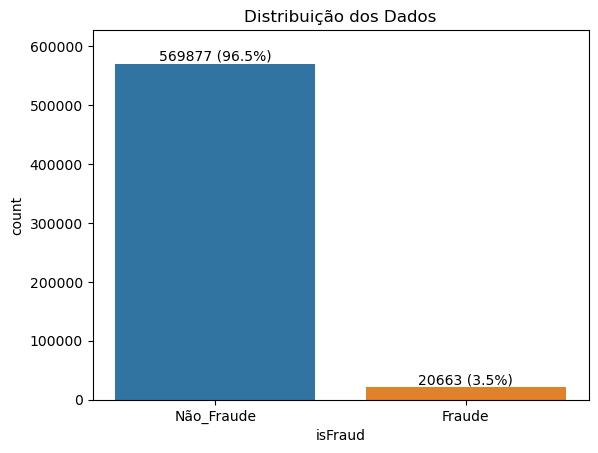

In [10]:
ax = sns.countplot(x='isFraud', data = train)

plt.title("Distribuição dos Dados")

plt.margins(0.05, 0.1)

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{} ({:.1f}%)'.format(int(y),100.*y/len(train)), (x.mean(), y), 
          ha='center', va='bottom') 
plt.xticks([0, 1], ['Não_Fraude', 'Fraude'])
plt.show()

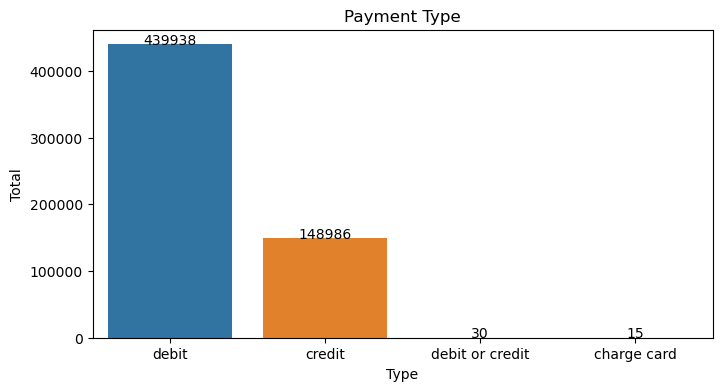

In [11]:
labels=train['card6'].value_counts().index
values=train['card6'].value_counts().values

plt.figure(figsize = (8, 4))
ax = sns.barplot(x=labels, y=values)
ax.set_title('Payment Type')
ax.set_ylabel('Total')
ax.set_xlabel('Type')
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height, values[i],ha="center")

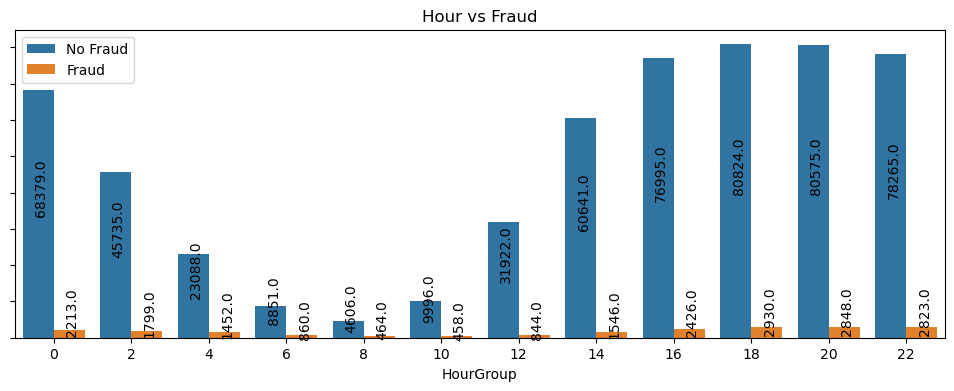

In [12]:
#A Coluna TransactionDT nos diz sobre horário, iremos efetuar um relacionamento com a fraude para entender os picos de acontecimento.

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.countplot(x='HourGroup', hue='isFraud', data=train, ax=ax)
ax.set_title('Hour vs Fraud')
ax.legend(['No Fraud', 'Fraud'])
ax.set_ylabel('')
ax.set_yticklabels('')
total0 = len(train["HourGroup"])
for p in ax.patches:
    percentage = '{:.1f}'.format((((p.get_height()/total0)*100)*total0)/100)
    x = p.get_x() + p.get_width()/2 - 0.05
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y),rotation=90, size = 10)

plt.show()

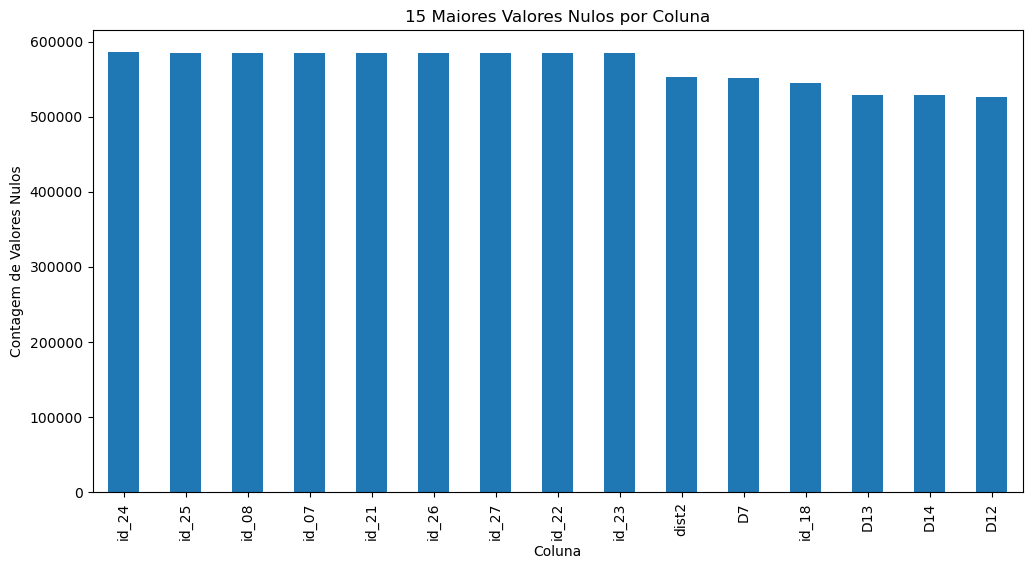

In [13]:
# Calcule a contagem de valores nulos em cada coluna
null_counts = train.isnull().sum()

# Selecione apenas os 15 maiores valores nulos
top_null_counts = null_counts.sort_values(ascending=False).head(15)

# Crie um histograma de valores nulos para os 15 maiores
plt.figure(figsize=(12, 6))
top_null_counts.plot(kind='bar')
plt.title('15 Maiores Valores Nulos por Coluna')
plt.xlabel('Coluna')
plt.ylabel('Contagem de Valores Nulos')
plt.xticks(rotation=90)
plt.show()

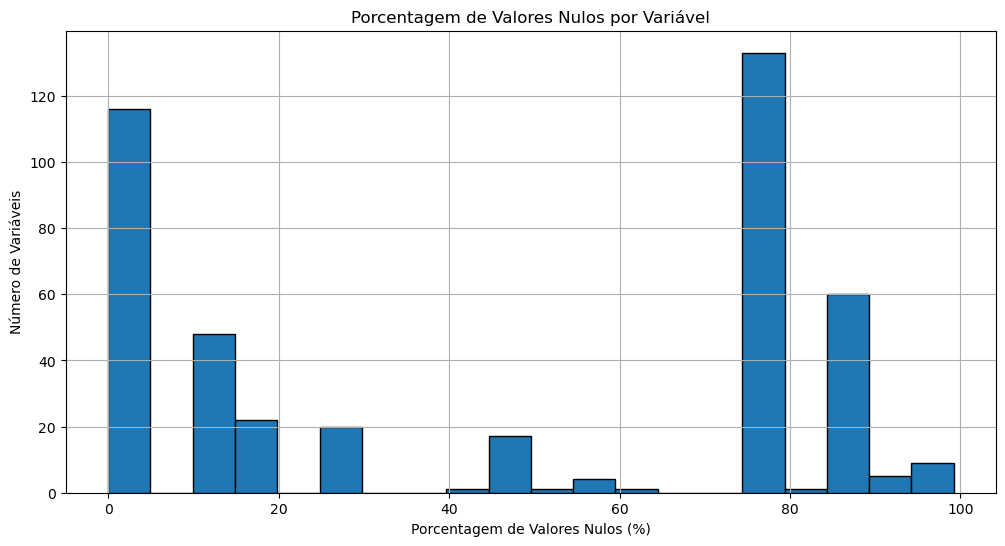

In [14]:
# Calcule a porcentagem de valores nulos por variável
percentage_missing = (train.isnull().sum() / len(train)) * 100

# Crie um histograma para visualizar as porcentagens de valores nulos
plt.figure(figsize=(12, 6))
plt.hist(percentage_missing, bins=20, edgecolor='k')
plt.title('Porcentagem de Valores Nulos por Variável')
plt.xlabel('Porcentagem de Valores Nulos (%)')
plt.ylabel('Número de Variáveis')
plt.grid(True)
plt.show()

In [15]:
# Converta a coluna de data para o tipo datetime, se necessário
train['TransactionDT'] = pd.to_datetime(train['TransactionDT'], unit='s')

# Crie uma coluna para o dia da transação
train['TransactionDay'] = train['TransactionDT'].dt.date

# Calcule a porcentagem de fraude por dia
fraud_by_day = train.groupby('TransactionDay')['isFraud'].mean() * 100

# Calcule a média da porcentagem de fraude
average_fraud = fraud_by_day.mean()

# Crie um gráfico de linha para mostrar a porcentagem de fraude por dia
plt.figure(figsize=(12, 5))
plt.plot(fraud_by_day.index, fraud_by_day.values, marker='o', linestyle='-', label='Porcentagem de Fraude')
plt.axhline(y=average_fraud, color='r', linestyle='--', label='Média de Fraude')
plt.title('Porcentagem de Fraude por Dia')
plt.xlabel('Data')
plt.ylabel('Porcentagem de Fraude (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()  # Adicione uma legenda ao gráfico

# Exiba o gráfico
plt.show()

KeyError: 'TransactionDT'

In [ ]:
f,ax=plt.subplots(1,1, figsize=(16,6))
cnt = sns.countplot(x='TransDay',hue='isFraud', data=train, ax=ax)
ax.set_title('TransactionDT(Day) vs Fraud')
ax.legend(['No Fraud','Fraud'])
ax.set_ylabel('')
ax.set_yticklabels('')
total0 =len(train["TransDay"])
for i, p in enumerate(ax.patches):
    percentage = '{:.1f}'.format((((p.get_height()/total0)*100)*total0)/100)
    x = p.get_x() + p.get_width()/2 - 0.05
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y),rotation=90, size = 10)

In [ ]:
f,ax=plt.subplots(1,1, figsize=(16,6))
cnt = sns.countplot(x='TransWeek',hue='isFraud', data=train, ax=ax)
ax.set_title('TransactionDT(Week) vs Fraud')
ax.legend(['No Fraud','Fraud'])
ax.set_ylabel('')
ax.set_yticklabels('')
total0 =len(train["TransWeek"])
for i, p in enumerate(ax.patches):
    percentage = '{:.1f}'.format((((p.get_height()/total0)*100)*total0)/100)
    x = p.get_x() + p.get_width()/2 - 0.05
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y),rotation=90, size = 10)

In [ ]:
f,ax=plt.subplots(1,1, figsize=(16,6))
cnt = sns.countplot(x='TransMonth',hue='isFraud', data=train, ax=ax)
ax.set_title('TransactionDT(Month) vs Fraud')
ax.legend(['No Fraud','Fraud'])
ax.set_ylabel('')
ax.set_yticklabels('')
total0 =len(train["TransMonth"])
for i, p in enumerate(ax.patches):
    percentage = '{:.1f}'.format((((p.get_height()/total0)*100)*total0)/100)
    x = p.get_x() + p.get_width()/2 - 0.05
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y),rotation=90, size = 10)

In [ ]:
#Analise de Plot pela massa total de dados.

f,ax=plt.subplots(1,3, figsize=(18,6))
cnt = sns.countplot(x='ProductCD',hue='isFraud', data=train, ax=ax[0])
ax[0].set_title('Fraud vs No Fraud by Product Category')
ax[0].legend(['No Fraud','Fraud'])
ax[0].set_ylabel('')
ax[0].set_yticklabels('')
total0 =len(train["ProductCD"])
for i, p in enumerate(ax[0].patches):
    percentage = '{:.1f}'.format((((p.get_height()/total0)*100)*total0)/100)
    x = p.get_x() + p.get_width()/2 - 0.05
    y = p.get_y() + p.get_height()/2
    ax[0].annotate(percentage, (x, y),rotation=90, size = 10)


cnt2 = sns.countplot(x='card4',hue='isFraud', data=train, ax=ax[1])
ax[1].set_title('Fraud vs No Fraud Type of card')
ax[1].legend(['No Fraud','Fraud'])
ax[1].set_ylabel('')
ax[1].set_yticklabels('')

total =len(train["card4"])
for i, p in enumerate(ax[1].patches):
    percentage = '{:.1f}'.format((((p.get_height()/total)*100)*total)/100)
    x = p.get_x() + p.get_width()/2 - 0.05
    y = p.get_y() + p.get_height()/2
    ax[1].annotate(percentage, (x, y),rotation=90, size = 10)

cnt3 = sns.countplot(x='card6',hue='isFraud', data=train, ax=ax[2])
ax[2].set_title('Fraud vs No Fraud by Type of Payment')
ax[2].legend(['No Fraud','Fraud'])
ax[2].set_ylabel('')
ax[2].set_yticklabels('')
total3 =len(train["card6"])
for i, p in enumerate(ax[2].patches):
    percentage = '{:.1f}'.format((((p.get_height()/total3)*100)*total3)/100)
    x = p.get_x() + p.get_width()/2 - 0.05
    y = p.get_y() + p.get_height()/2
    ax[2].annotate(percentage, (x, y),rotation=90, size = 10)

plt.show()